In [2]:
!pip install pennylane

In [3]:
from sklearn import datasets

iris = datasets.load_iris()
X = np.array(iris['data'], requires_grad=True)
y = np.array(iris['target'], requires_grad=True)
X, y

(tensor([[5.1, 3.5, 1.4, 0.2],
         [4.9, 3. , 1.4, 0.2],
         [4.7, 3.2, 1.3, 0.2],
         [4.6, 3.1, 1.5, 0.2],
         [5. , 3.6, 1.4, 0.2],
         [5.4, 3.9, 1.7, 0.4],
         [4.6, 3.4, 1.4, 0.3],
         [5. , 3.4, 1.5, 0.2],
         [4.4, 2.9, 1.4, 0.2],
         [4.9, 3.1, 1.5, 0.1],
         [5.4, 3.7, 1.5, 0.2],
         [4.8, 3.4, 1.6, 0.2],
         [4.8, 3. , 1.4, 0.1],
         [4.3, 3. , 1.1, 0.1],
         [5.8, 4. , 1.2, 0.2],
         [5.7, 4.4, 1.5, 0.4],
         [5.4, 3.9, 1.3, 0.4],
         [5.1, 3.5, 1.4, 0.3],
         [5.7, 3.8, 1.7, 0.3],
         [5.1, 3.8, 1.5, 0.3],
         [5.4, 3.4, 1.7, 0.2],
         [5.1, 3.7, 1.5, 0.4],
         [4.6, 3.6, 1. , 0.2],
         [5.1, 3.3, 1.7, 0.5],
         [4.8, 3.4, 1.9, 0.2],
         [5. , 3. , 1.6, 0.2],
         [5. , 3.4, 1.6, 0.4],
         [5.2, 3.5, 1.5, 0.2],
         [5.2, 3.4, 1.4, 0.2],
         [4.7, 3.2, 1.6, 0.2],
         [4.8, 3.1, 1.6, 0.2],
         [5.4, 3.4, 1.5, 0.4],
        

In [41]:
import pennylane as qml
import torch
from torch.autograd import Variable
from pennylane import numpy as np

num_wires = 4
num_layers = 2

dev = qml.device("default.qubit", wires=num_wires)

coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]
H = qml.Hamiltonian(coeffs, obs)

#START HERE
'''
@qml.qnode(dev, interface='autograd')
def circuit(params, x=x):
  qml.RX(params[0], wires=0)
  qml.RZ(params[1], wires=0)
  for i in range(1, num_wires):
    qml.CNOT([i-1, i])
    qml.RX(params[0], wires=i)
    qml.RZ(params[1], wires=i)
  return qml.expval(qml.PauliZ(0))

def circuit_0_1(params):
  print('check i', circuit(params))
  return (circuit(params) + 1)/2
'''

@qml.qnode(dev, interface='autograd')
def circuit(params, x):
  x /= np.linalg.norm(x)
  #qml.AmplitudeEmbedding(x, wires=list(range(num_wires)))
  qml.AngleEmbedding(features=x, wires=range(num_wires), rotation='Y')
  qml.BasicEntanglerLayers(weights=params, wires=range(num_wires))

  return qml.expval(H)

  #print('state', qml.state())
  ##print('full_circuit_1', circuit_0_1(params))
  #return circuit_0_1(params)

#def binary_cost(params):
#  return circuit_0_1

def full_circuit(params, x):
  ###print('circuit result', circuit(params, x))
  return (np.array(circuit(params, x)).mean() + 1)/2

def square_loss(labels, predictions):
    loss = 0
    ##print(labels, predictions)
    for true, pred in zip(labels, predictions):
        ##print(true, pred)
        loss = loss + (true - pred) ** 2

    loss = loss / len(labels)
    return loss

def cross_loss(labels, predictions):
    loss = 0
    for true, pred in zip(labels, predictions):
      #print(true*np.log(pred + 1))
      loss = loss + true*np.log(pred) + (1-true)*np.log(1 - pred)
    loss = - loss/len(labels)
    return loss

def accuracy(labels, predictions):
    #loss = (labels - predictions).sum()
    loss1 = 0
    loss2 = 0
    ##print('accuracy', labels, predictions)
    for true, pred in zip(labels, predictions):
        if true - pred < 0.5:
            loss1 = loss1 + 1
        if true - pred > 0.5:
            loss2 = loss2 + 1
    acc1 = loss1 / len(labels)
    acc2 = loss2 / len(labels)
    return max(acc1, acc2)

def cost(params, X_batch, y_batch):
    #predictions = full_circuit(params, X_batch)
    ##print('X_batch.shape',X_batch.shape)
    data_indices = [np.random.randint(0, len(X)) for _ in range(1)]
    predictions = [full_circuit(params, X_batch[index]) for index in data_indices]
    ##print('len(predictions)',len(predictions))
    #predictions = full_circuit(params, X_batch.flatten())
    ##print('Cost',y_batch, predictions)
    return cross_loss(y_batch[data_indices], predictions)

'''
def circuit_probs(params):
  qml.RX(params[0], wires=0)
  qml.RZ(params[1], wires=0)
  return qml.probs(wires=0)

def cost_probs(params):
  return circuit_probs - data'''

optimizer = qml.AdamOptimizer(stepsize=0.01)
params = np.array([[0.3, 0.5, 0.3, 0.5], [0.5, 0.5, 0.3, 0.5]], requires_grad=True)

#X = np.array([[1., 1., 0., 0.], [0., 0., 1., 1.], [1., 0., 1., 0.], [0., 1., 0., 1.]], requires_grad=True)
#y = np.array([0, 0, 1, 1], requires_grad=True)

losses = []

for it in range(100):
  #data_index = np.random.randint(0, len(X))
  #X_batch = X[data_index]
  #y_batch = y[data_index]

  X_batch = X
  y_batch = y
  params, loss = optimizer.step_and_cost(cost, params, X_batch=X_batch, y_batch=y_batch)
  print('step', it, params, loss)
  losses.append(loss)

  predictions = [full_circuit(params, x) for x in X]
  print('step', it, 'params', params, 'loss', loss, 'predictions', predictions)
  #predictions = full_circuit(params, X.flatten())
  acc = accuracy(y, predictions)

  print(
      "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
          it + 1, cost(params, X, y), acc
      )
  )

'''state_preparation(x)

losses = []
for i in range(400):
  params, loss = optimizer.step_and_cost(circuit, params)
  losses.append(loss)
  print(loss)'''


#END HERE

step 0 [[0.3        0.49       0.29000003 0.5       ]
 [0.49       0.5        0.29000003 0.49000001]] 0.35658584877518806
step 0 params [[0.3        0.49       0.29000003 0.5       ]
 [0.49       0.5        0.29000003 0.49000001]] loss 0.35658584877518806 predictions [tensor(0.70546527, requires_grad=True), tensor(0.68764913, requires_grad=True), tensor(0.70546527, requires_grad=True), tensor(0.68764913, requires_grad=True)]
Iter:     1 | Cost: 1.1636282 | Accuracy: 1.0000000 
step 1 [[0.3        0.49425228 0.29451558 0.5       ]
 [0.49425941 0.5        0.29451558 0.49434707]] 1.222358361430949
step 1 params [[0.3        0.49425228 0.29451558 0.5       ]
 [0.49425941 0.5        0.29451558 0.49434707]] loss 1.222358361430949 predictions [tensor(0.70313793, requires_grad=True), tensor(0.6848106, requires_grad=True), tensor(0.70313793, requires_grad=True), tensor(0.6848106, requires_grad=True)]
Iter:     2 | Cost: 1.1545816 | Accuracy: 1.0000000 
step 2 [[0.3        0.49502091 0.2955271  

'state_preparation(x)\n\nlosses = []\nfor i in range(400):\n  params, loss = optimizer.step_and_cost(circuit, params)\n  losses.append(loss)\n  print(loss)'

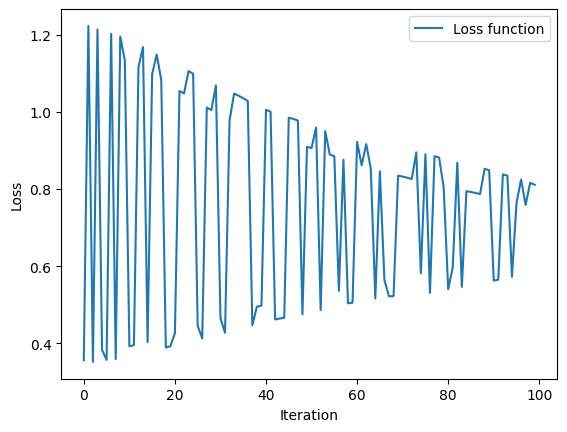

In [42]:
import matplotlib.pyplot as plt

plt.plot(losses, label='Loss function')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

In [39]:
import pennylane as qml
import torch
from torch.autograd import Variable
from pennylane import numpy as np

num_wires = 4
num_layers = 2

dev = qml.device("default.qubit", wires=num_wires)

coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]
H = qml.Hamiltonian(coeffs, obs)

#START HERE
'''
@qml.qnode(dev, interface='autograd')
def circuit(params, x=x):
  qml.RX(params[0], wires=0)
  qml.RZ(params[1], wires=0)
  for i in range(1, num_wires):
    qml.CNOT([i-1, i])
    qml.RX(params[0], wires=i)
    qml.RZ(params[1], wires=i)
  return qml.expval(qml.PauliZ(0))

def circuit_0_1(params):
  print('check i', circuit(params))
  return (circuit(params) + 1)/2
'''

@qml.qnode(dev, interface='autograd')
def circuit(params, x):
  x /= np.linalg.norm(x)
  #qml.AmplitudeEmbedding(x, wires=list(range(num_wires)))
  qml.AngleEmbedding(features=x, wires=range(num_wires), rotation='Y')
  qml.BasicEntanglerLayers(weights=params, wires=range(num_wires))

  return qml.expval(H)

  #print('state', qml.state())
  ##print('full_circuit_1', circuit_0_1(params))
  #return circuit_0_1(params)

#def binary_cost(params):
#  return circuit_0_1

def full_circuit(params, x):
  ###print('circuit result', circuit(params, x))
  return (np.array(circuit(params, x)).mean() + 1)/2

def square_loss(labels, predictions):
    loss = 0
    ##print(labels, predictions)
    for true, pred in zip(labels, predictions):
        ##print(true, pred)
        loss = loss + (true - pred) ** 2

    loss = loss / len(labels)
    return loss

def cross_loss(labels, predictions):
    loss = 0
    for true, pred in zip(labels, predictions):
      #print(true*np.log(pred + 1))
      loss = loss + true*np.log(pred) + (1-true)*np.log(1 - pred)
    loss = - loss/len(labels)
    return loss

def accuracy(labels, predictions):
    #loss = (labels - predictions).sum()
    loss1 = 0
    loss2 = 0
    ##print('accuracy', labels, predictions)
    for true, pred in zip(labels, predictions):
        if true - pred < 0.5:
            loss1 = loss1 + 1
        if true - pred > 0.5:
            loss2 = loss2 + 1
    acc1 = loss1 / len(labels)
    acc2 = loss2 / len(labels)
    return max(acc1, acc2)

def cost(params, X_batch, y_batch):
    #predictions = full_circuit(params, X_batch)
    ##print('X_batch.shape',X_batch.shape)
    data_indices = [np.random.randint(0, len(X)) for _ in range(1)]
    predictions = [full_circuit(params, X_batch[index]) for index in data_indices]
    ##print('len(predictions)',len(predictions))
    #predictions = full_circuit(params, X_batch.flatten())
    ##print('Cost',y_batch, predictions)
    return cross_loss(y_batch[data_indices], predictions)

'''
def circuit_probs(params):
  qml.RX(params[0], wires=0)
  qml.RZ(params[1], wires=0)
  return qml.probs(wires=0)

def cost_probs(params):
  return circuit_probs - data'''

optimizer = qml.AdamOptimizer(stepsize=0.01)
params = np.array([[0.3, 0.5, 0.3, 0.5], [0.5, 0.5, 0.3, 0.5]], requires_grad=True)

X = np.array([[1., 1., 0., 0.], [0., 0., 1., 1.], [1., 0., 1., 0.], [0., 1., 0., 1.]], requires_grad=True)
y = np.array([0, 0, 1, 1], requires_grad=True)

losses = []

for it in range(100):
  #data_index = np.random.randint(0, len(X))
  #X_batch = X[data_index]
  #y_batch = y[data_index]

  X_batch = X
  y_batch = y
  params, loss = optimizer.step_and_cost(cost, params, X_batch=X_batch, y_batch=y_batch)
  print('step', it, params, loss)
  losses.append(loss)

  predictions = [full_circuit(params, x) for x in X]
  print('step', it, 'params', params, 'loss', loss, 'predictions', predictions)
  #predictions = full_circuit(params, X.flatten())
  acc = accuracy(y, predictions)

  print(
      "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
          it + 1, cost(params, X, y), acc
      )
  )

'''state_preparation(x)

losses = []
for i in range(400):
  params, loss = optimizer.step_and_cost(circuit, params)
  losses.append(loss)
  print(loss)'''


#END HERE

step 0 [[0.3        0.49000001 0.29000001 0.5       ]
 [0.49       0.5        0.29000001 0.49      ]] 0.38399258872749886
step 0 params [[0.3        0.49000001 0.29000001 0.5       ]
 [0.49       0.5        0.29000001 0.49      ]] loss 0.38399258872749886 predictions [tensor(0.70546527, requires_grad=True), tensor(0.68764914, requires_grad=True), tensor(0.70546527, requires_grad=True), tensor(0.68764914, requires_grad=True)]
Iter:     1 | Cost: 1.1636282 | Accuracy: 1.0000000 
step 1 [[0.3        0.47999957 0.28000087 0.5       ]
 [0.48000094 0.5        0.28000087 0.48000094]] 0.3744765445158933
step 1 params [[0.3        0.47999957 0.28000087 0.5       ]
 [0.48000094 0.5        0.28000087 0.48000094]] loss 0.3744765445158933 predictions [tensor(0.71092773, requires_grad=True), tensor(0.69419919, requires_grad=True), tensor(0.71092773, requires_grad=True), tensor(0.69419919, requires_grad=True)]
Iter:     2 | Cost: 0.3411845 | Accuracy: 1.0000000 
step 2 [[0.3        0.4699988  0.27000

'state_preparation(x)\n\nlosses = []\nfor i in range(400):\n  params, loss = optimizer.step_and_cost(circuit, params)\n  losses.append(loss)\n  print(loss)'

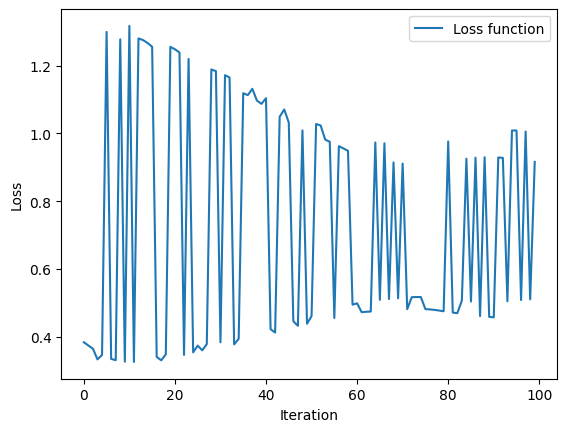

In [40]:
import matplotlib.pyplot as plt

plt.plot(losses, label='Loss function')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()